## Imports

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [98]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [84]:
def apply_phase_shift(u, v, V, dRA, dDec, inverse=False):
    r"""
    Apply a phase shift to the visibilities.

    This is equivalent to moving the source in the image plane by the
    vector (dRA, dDec).

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    V : array of real, size = N, unit = Jy
        Complex visibilites
    dRA : float, unit = arcsec
        Phase shift in right ascenion.
    dDec : float, unit = arcsec
        Phase shift in declination.
    inverse : bool, default=False
        If True, the phase shift is reversed (equivalent to
        flipping the signs of dRA and dDec).
    Returns
    -------
    shifted_vis : array of real, size = N, unit = Jy
        Phase shifted visibilites

    """
    dRA *= 2. * np.pi / const.rad_to_arcsec
    dDec *= 2. * np.pi / const.rad_to_arcsec

    phi = u * dRA + v * dDec

    if inverse:
        shifted_vis = V / (np.cos(phi) + 1j * np.sin(phi))
    else:
        shifted_vis = V * (np.cos(phi) + 1j * np.sin(phi))

    return shifted_vis

In [97]:
 def apply_correction(u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [53]:
from scipy.ndimage import gaussian_filter1d
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'median', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    I_smoothed = gaussian_filter1d(I_binned, sigma=1)

    return r_centers, I_smoothed

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

### Data

In [6]:
# Huang 2018 for Elias24
inc = 29
pa = 45.7
dra = -110.8e-3
ddec = -386.8e-3
Rout = 2.1 #arcsecs


# UVtable
dir = "../../../data/"
data_file = dir +'Elias24_continuum_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geometry = {"inc": inc, "pa": pa, "dra": dra, "ddec":ddec}

# Frank2D

In [65]:
N = 300

In [66]:
frank2d0 = Frank2D(N, Rout, geometry = geometry)

In [67]:
m, c, l = -0.33, -0.1, 1e5

In [68]:
frank2d0.preprocess_vis(u, v, Vis, Weights, hermitian = True, vis_part = 'Imag')

  --> time = 0.22  min |  13.14 seconds
Setting gridded data...


In [69]:
vis_gridded = frank2d0._gridded_data['vis']

In [70]:
vis_gridded

array([0.-0.01001309j, 0.+0.0805726j , 0.+0.09322749j, ...,
       0.-0.07292619j, 0.-0.09475061j, 0.-0.10975384j])

In [71]:
FT = frank2d0._FT
x_labels = np.fft.fftshift(FT._u/1e6)
y_labels = np.fft.fftshift(FT._v/1e6)

num_ticks = 5
x_ticks_to_show = np.linspace(0, len(x_labels) - 1, num_ticks).astype(int)
y_ticks_to_show = np.linspace(0, len(y_labels) - 1, num_ticks).astype(int)

def format_labels(x):
    return f"{int(x):d}" if abs(x) > 1e-8 else "0"

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_89911/522996837.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.imag.reshape(frank2d0._FT._Nx, frank2d0._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)


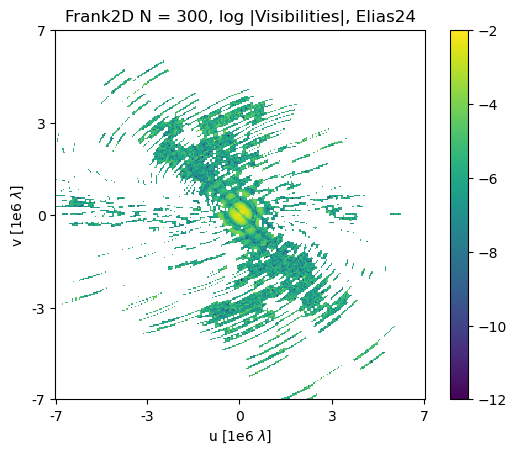

In [73]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.imag.reshape(frank2d0._FT._Nx, frank2d0._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Frank2D N = {N}, log |Visibilities|, Elias24')
plt.colorbar()

In [15]:
start_time = time.time()

#####

frank2d = Frank2D(N, Rout, geometry =  geometry)
frank2d.set_kernel('Wendland', [m, c, l])
frank2d.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel: Wendland...
Gridding...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:51: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.26  min |  15.56 seconds
Setting gridded data...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 7.39  min |  443.18 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 4.52758550754123e-09
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
   

In [18]:
start_time = time.time()

#####

frank2d_re = Frank2D(N, Rout, geometry = geometry)
frank2d_re.preprocess_vis(u, v, Vis, Weights, vis_part = 'Real')
frank2d_re.set_kernel('Wendland', [m, c, l])
frank2d_re.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

  --> time = 0.19  min |  11.12 seconds
Setting gridded data...
Setting kernel: Wendland...
Gridding...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 4.71  min |  282.67 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 3.993034728114375e-09
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteratio

In [19]:
start_time = time.time()

#####

frank2d_im = Frank2D(N, Rout, geometry = geometry)
frank2d_im.preprocess_vis(u, v, Vis, Weights, vis_part = 'Imag')
frank2d_im.set_kernel('Wendland', [m, c, l])
frank2d_im.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

  --> time = 0.17  min |  10.06 seconds
Setting gridded data...
Setting kernel: Wendland...
Gridding...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 7.92  min |  475.38 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 1.5458612262827357e-09
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iterati

In [60]:
frank2d_tot = Frank2D(N, Rout, geometry = geometry)
frank2d_tot.sol_visibility = frank2d_re.sol_visibility + frank2d_im.sol_visibility
frank2d_tot.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


In [27]:
vis_sol_tot = frank2d_tot.sol_visibility.reshape(frank2d._FT._Nx, frank2d._FT._Ny)

In [30]:
frank2d_tot.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


In [28]:
vis_sol = frank2d.sol_visibility.reshape(frank2d._FT._Nx, frank2d._FT._Ny)

In [34]:
frank2d.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.01 seconds


/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_89911/1027699415.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_tot.imag- vis_sol.imag))), origin='lower', vmin=-12, vmax=-2)


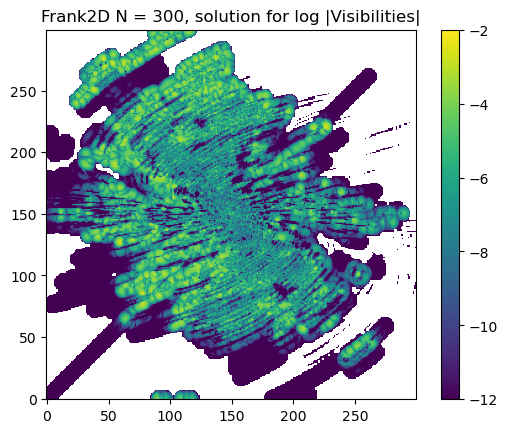

In [64]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_tot.imag- vis_sol.imag))), origin='lower', vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

In [80]:
import constants as const
class Plot():
    def __init__(self, Frank2D):
        self._frank2d = Frank2D
        
    def get_image(self, title = "Model", add_fourier_resolution = False, log_norm = False, reproject = False):
        frank2d = self._frank2d
        I = frank2d.sol_intensity
        Nx = frank2d._Nx
        Ny = frank2d._Ny
        dx = frank2d._FT._dx*const.rad_to_arcsec
        dy = frank2d._FT._dy*const.rad_to_arcsec
        Rout = frank2d._Rmax*const.rad_to_arcsec

        x = frank2d._FT._x*const.rad_to_arcsec
        y = frank2d._FT._y*const.rad_to_arcsec

        if reproject:
            geom = self._frank2d._geometry
            inc, pa = geom['inc'], geom['pa']
            inc *= const.deg_to_rad
            pa *= const.deg_to_rad
    
            cos_i = np.cos(inc)
            cos_pa, sin_pa = np.cos(pa), np.sin(pa)
            
            x  = x * cos_pa + y * sin_pa
            y  = -x * sin_pa + y * cos_pa
            x /= cos_i


        # Coordenadas del pixel que quieres mostrar
        pixel_x, pixel_y = Nx//2, Ny//2
        pixel_value = I[pixel_x, pixel_y]

        # Crear una figura con dos subplots
        if add_fourier_resolution:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})
        else:
            fig, ax = plt.subplots(1, 1, figsize=(7, 4))
            axs = [ax]
        
        norm = LogNorm() if log_norm else None

        # Primer subplot.
        plot = axs[0].pcolormesh(x[::-1], y, I, cmap='magma', norm=norm)
        axs[0].invert_xaxis()
        cmap = plt.colorbar(plot, ax=axs[0])
        cmap.set_label(r'I [Jy $sr^{-1}$]', size=15)

        axs[0].set_title(title)
        axs[0].set_xlabel("dRa ['']")
        axs[0].set_ylabel("dDec ['']")

        xlim = axs[0].get_xlim()
        ylim = axs[0].get_ylim()

        base_x = xlim[0] + 0.05 * (xlim[1] - xlim[0])  # 5% desde el borde izquierdo
        base_y = ylim[0] + 0.05 * (ylim[1] - ylim[0])  # 5% desde el borde inferior
        
        # Texto combinado en un solo cuadro
        text_combined = (
            r"$" + str(Nx)+"^{2}$ pixels" + "  |  "
            r"FOV: " + str(2 * Rout) + "''"
        )
        
        # Mostrar el texto combinado en una sola caja
        axs[0].text(
            base_x,
            base_y,
            text_combined,
            ha="left",
            va="bottom",
            bbox={'facecolor': 'white', 'pad': 5, 'alpha': 0.8},
            fontsize=10
        )
                
        if add_fourier_resolution:
            # Segundo subplot: el pixel específico
            # Creamos una matriz de ceros y luego establecemos el valor del píxel deseado en I[pixel_y, pixel_x]
            pixel_image = np.zeros((1, 1))
            pixel_image[0, 0] = pixel_value
            img = axs[1].imshow(pixel_image, cmap="magma", extent=[0, 1, 0, 1])
            axs[1].set_title(f'Pixel at ({pixel_x}, {pixel_y})')
            axs[1].set_xticks([])
            axs[1].set_yticks([])

            # Colorbar para el pixel específico
            cmap_pixel = plt.colorbar(img, ax=axs[1], shrink=0.5)
            cmap_pixel.set_label(r'I [Jy $sr^{-1}$]', size=9)

            # Configurar notación científica en la barra de color
            cmap_pixel.formatter.set_powerlimits((-2, 2))  # Limitar la notación científica a potencias entre -3 y 3
            cmap_pixel.update_ticks()

            # Mostrar el valor del pixel como leyenda
            axs[1].text(0.5, -0.3, f'Intensity: {pixel_value:.4}', ha='center', va='center', transform=axs[1].transAxes, fontsize=9, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3})

            # Agregar indicaciones del largo del pixel en los ejes x y y
            axs[1].annotate('', xy=(0, 0), xytext=(1, 0), arrowprops=dict(arrowstyle='<->', color='black'))
            axs[1].text(0.5, -0.05, f'{dx: .5f} ["]', ha='center', va='top', transform=axs[1].transAxes)

            axs[1].annotate('', xy=(0, 0), xytext=(0, 1), arrowprops=dict(arrowstyle='<->', color='black'))
            axs[1].text(-0.05, 0.5, f'{dy: .5f}  ["]', ha='right', va='center', transform=axs[1].transAxes, rotation='vertical')

            # Ajustar el tamaño de los subplots
            plt.tight_layout()
            plt.subplots_adjust(wspace=0.2)

        plt.show()

In [89]:
vis_phase_shifted = deproject(FT._Un, FT._Vn, frank2d.sol_visibility, dra, ddec,  inverse= True)

In [93]:
frank2d_phase_shifted = Frank2D(N, Rout, geometry = geometry)
frank2d_phase_shifted.sol_visibility = vis_phase_shifted
frank2d_phase_shifted.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


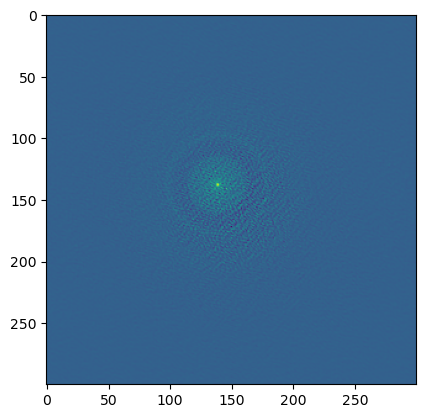

In [96]:
plt.imshow(frank2d.sol_intensity.reshape(frank2d._FT._Nx, frank2d._FT._Ny))

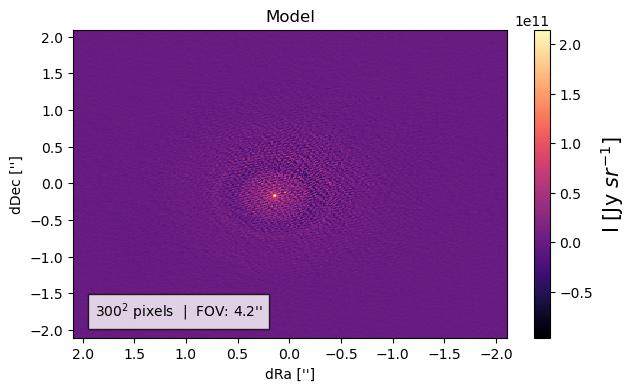

In [82]:
Plot(frank2d).get_image()

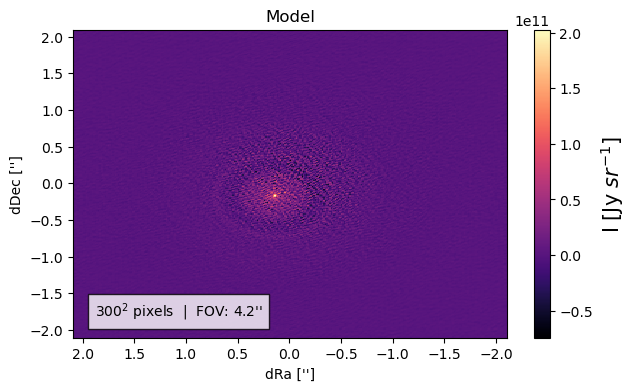

In [78]:
Plot(frank2d_tot).get_image()

In [54]:
r, I = get_radial_profile(frank2d_tot)

In [40]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-3

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

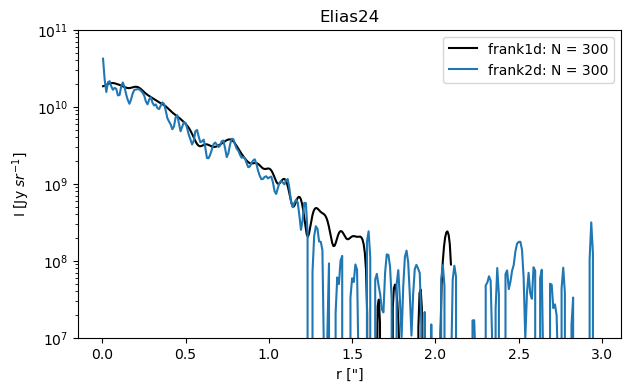

In [55]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d: N = {n_pts}')
plt.plot(r, I, label = f'frank2d: N = {N}')
plt.xlabel('r ["]')
plt.title('Elias24')      
plt.ylim(1e7, 1e11)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.yscale("log")
plt.show()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_34096/3429611353.py:32: RuntimeWarning: invalid value encountered in divide
  return q_centers, Vis_Weights_binned/Weights_binned


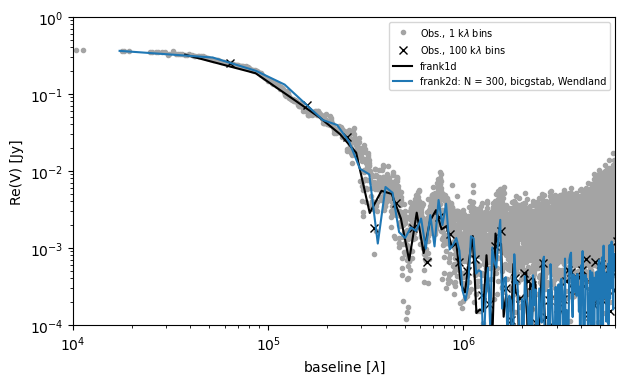

In [88]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend(fontsize =7)
plt.show()

### Comparing with CLEAN

In [311]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [312]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank2d = convolve_profile(r, I, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm

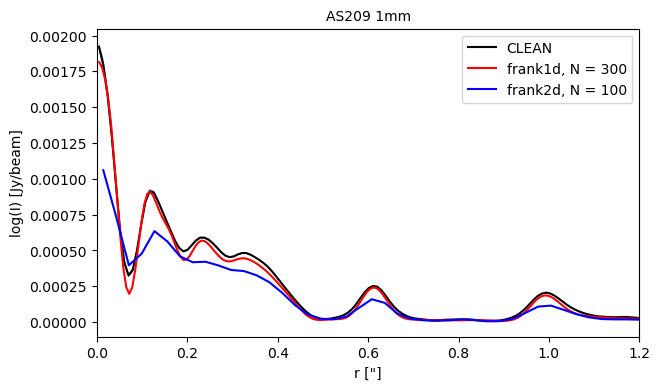

In [313]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm, "black", label = "CLEAN")
plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d, "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r,convolved_1mm_frank2d, "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
#plt.yscale('log')
#plt.ylim(0.1e-5, 0.5e-2)
plt.xlim(0,1.2)
plt.show()